In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
 cd /content/gdrive/My Drive/CNN

/content/gdrive/My Drive/자료분석특론/프로젝트


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE) # default는 512
        # img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        if img is not None:
            images.append(img)
    return images

In [ ]:
folder = "./COVID_CT/Not_Infected"
n_infected = load_images_from_folder(folder)

In [ ]:
folder = "./COVID_CT/Infected"
infected = load_images_from_folder(folder)

In [ ]:
h, w = n_infected[0].shape # 마지막은 channel, 3이면 color, 1로 없으면 grey

In [ ]:
print(h)
print(w)

512
512


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

n_infected_ = img_to_array(n_infected)
infected_ = img_to_array(infected)

# 대비 제한 적응 히스토그램 평활화(CLAHE: Contrast-limited adaptive histogram equalization)

대비를 향상

In [ ]:
clahe = cv2.createCLAHE(clipLimit=3.0)
def clahe_enhancer(img, clahe, axes):
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()
        
    return(clahe_img)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


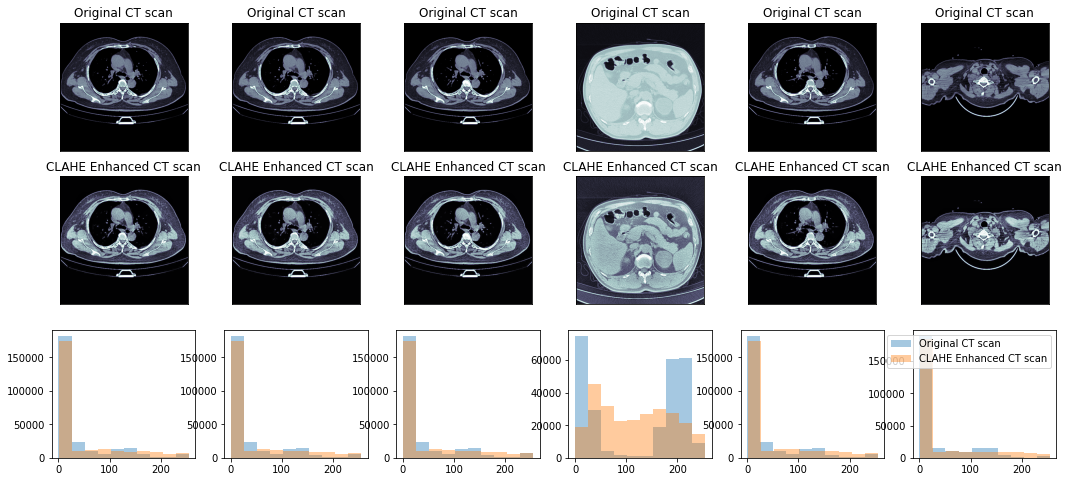

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(18,8))  
img_size = 512

for ii in range(0,6):
    img = cv2.resize(infected_[ii], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))

# 이미지 자르기(Cropping Images)

- 속도 개선에도 도움, 필요 없는 부분 자르기

In [ ]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9
    img = cv2.filter2D(img, -1, kernel)
    
    ret, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, 2, 1)
    #Areas = [cv.contourArea(cc) for cc in contours]; print(Areas)
    
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv2.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv2.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv2.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]
    
def crop_img(img, axes) :
    contours = get_contours(img)
    #plt.figure() # uncomment to troubleshoot
    #canvas = np.zeros_like(img)
    #cv.drawContours(canvas , contours, -1, (255, 255, 0), 1)
    #plt.imshow(canvas)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds

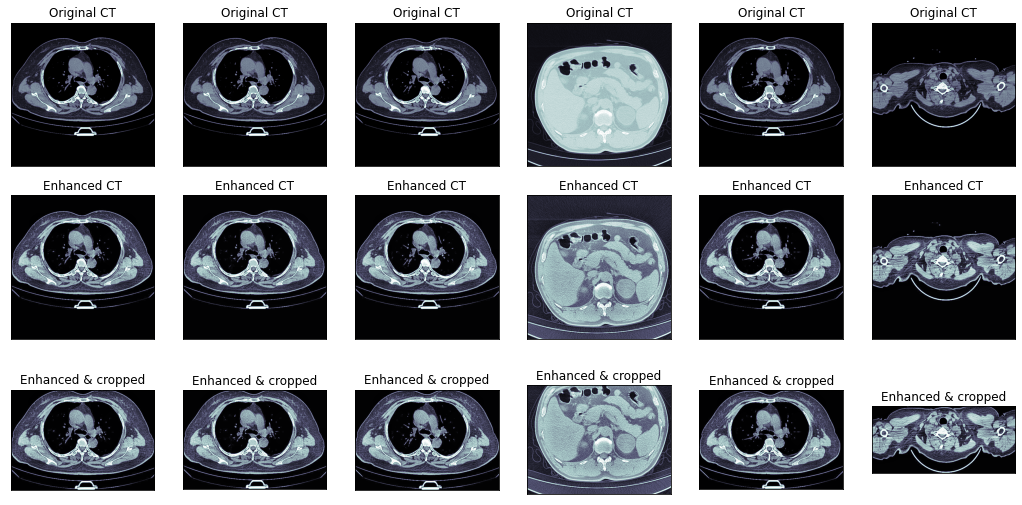

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(18,9))    

for ii in range(0,6):
    img = cv2.resize(infected_[ii], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    _, bounds = crop_img(img, [])
    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original CT')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced CT')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])
    
    cropped_img = crop_(clahe_img, bounds)
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Enhanced & cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

In [ ]:
infected_.shape

(501, 512, 512)

In [ ]:
# 전체에 적용, clahe, crop
infected_f = []

for ii in range(infected_.shape[0]):
    img_ct = cv2.resize(infected_[ii], dsize=(img_size, img_size), 
                        interpolation=cv2.INTER_AREA)
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    infected_f.append(cropped_ct)

In [ ]:
# 전체에 적용, clahe, crop
n_infected_f = []

for ii in range(n_infected_.shape[0]):
    img_ct = cv2.resize(n_infected_[ii], dsize=(img_size, img_size), 
                        interpolation=cv2.INTER_AREA)
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    n_infected_f.append(cropped_ct)

In [ ]:
# resize and reshape
num_pix = 512
del_lst = []
for ii in tqdm.tqdm(range(len(infected_f))) :
    try :
        infected_f[ii] = cv2.resize(infected_f[ii], dsize=(num_pix, num_pix), interpolation=cv2.INTER_AREA)
        infected_f[ii] = np.reshape(infected_f[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del infected_f[idx]

100%|██████████| 501/501 [00:00<00:00, 3967.20it/s]


In [ ]:
# resize and reshape
num_pix = 512
del_lst = []
for ii in tqdm.tqdm(range(len(n_infected_f))) :
    try :
        n_infected_f[ii] = cv2.resize(n_infected_f[ii], dsize=(num_pix, num_pix), interpolation=cv2.INTER_AREA)
        n_infected_f[ii] = np.reshape(n_infected_f[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del n_infected_f[idx]

100%|██████████| 550/550 [00:00<00:00, 3796.41it/s]


Text(0.5, 1.0, 'Enhanced & Cropped CT')

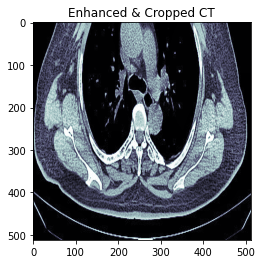

In [ ]:
plt.figure()

plt.imshow(infected_f[0][:,:,0], cmap='bone') # 0번째
plt.title("Enhanced & Cropped CT")

Text(0.5, 1.0, 'Enhanced & Cropped CT')

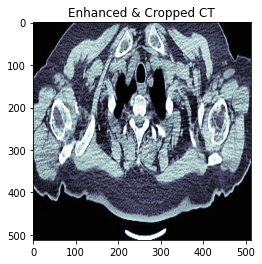

In [ ]:
plt.figure()

plt.imshow(infected_f[56][:,:,0], cmap='bone') # 56번째
plt.title("Enhanced & Cropped CT")

Text(0.5, 1.0, 'Enhanced & Cropped CT')

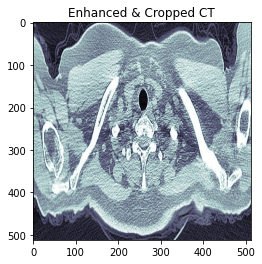

In [ ]:
plt.figure()

plt.imshow(n_infected_f[60][:,:,0], cmap='bone') # 0번째
plt.title("Enhanced & Cropped CT")

Text(0.5, 1.0, 'Enhanced & Cropped CT')

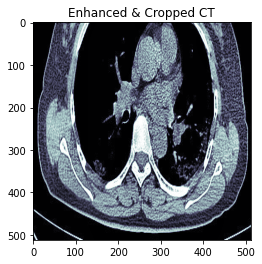

In [ ]:
plt.figure()

plt.imshow(n_infected_f[360][:,:,0], cmap='bone') # 0번째
plt.title("Enhanced & Cropped CT")

Text(0.5, 1.0, 'Enhanced & Cropped CT')

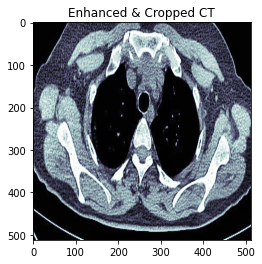

In [ ]:
plt.figure()

plt.imshow(n_infected_f[356][:,:,0], cmap='bone') # 0번째
plt.title("Enhanced & Cropped CT")

Text(0.5, 1.0, 'Enhanced & Cropped CT')

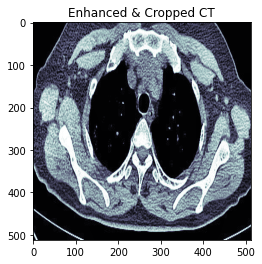

In [ ]:
plt.figure()

plt.imshow(n_infected_f[353][:,:,0], cmap='bone') # 0번째
plt.title("Enhanced & Cropped CT")

이 이미지들을 저장 후 augmentation을 위해 generate를 시도

# 데이터 저장

In [ ]:
# 랜덤하게 섞기
import random
random.seed(12345)

random.shuffle(n_infected_f)
random.shuffle(infected_f)

In [ ]:
# test(110, 100) - 20%, validate(55, 50)-10%, train(395, 351)-70% 비율

ntr = round(550*0.5)
nval = round(550*0.1)
nte = round(550*0.4)

itr = round(501*0.5)
ival = round(550*0.1)
ite = round(501*0.4)

In [ ]:
covid_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3'
os.mkdir(covid_dir)

train_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/train'
vali_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/validate'
test_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/test'

os.mkdir(train_dir)
os.mkdir(vali_dir)
os.mkdir(test_dir)

In [ ]:
train_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/train/Infected'
vali_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/validate/Infected'
test_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/test/Infected'

os.mkdir(train_dir)
os.mkdir(vali_dir)
os.mkdir(test_dir)

In [ ]:
train_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/train/n_Infected'
vali_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/validate/n_Infected'
test_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/test/n_Infected'

os.mkdir(train_dir)
os.mkdir(vali_dir)
os.mkdir(test_dir)

In [ ]:
import os, shutil

def ninfected_images_to_folder(n_infected):
    train_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/train/n_Infected/'
    vali_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/validate/n_Infected/'
    test_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/test/n_Infected/'

    for i in range(len(n_infected)):
        if i in range(0,ntr+1):
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(train_dir + fname)), n_infected[i])
            cv2.waitKey(0)
        elif i in range(ntr+1,ntr+nval+1):
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(vali_dir + fname)), n_infected[i])
            cv2.waitKey(0)
        else:
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(test_dir + fname)), n_infected[i])
            cv2.waitKey(0)

In [ ]:
def infected_images_to_folder(infected):
    train_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/train/Infected/'
    vali_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/validate/Infected/'
    test_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/test/Infected/'

    for i in range(len(infected)):
        if i in range(0,itr+1):
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(train_dir + fname)), infected[i])
            cv2.waitKey(0)
        elif i in range(itr+1,itr+ival+1):
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(vali_dir + fname)), infected[i])
            cv2.waitKey(0)
        else:
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(test_dir + fname)), infected[i])
            cv2.waitKey(0)

In [ ]:
ninfected_images_to_folder(n_infected_f)

In [ ]:
infected_images_to_folder(infected_f)